<a href="https://colab.research.google.com/github/francescomazzolin/stochastic-finance-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stochastic Finance Project

Giada Martini

Francesco Mazzolin

Francesco Salvagnin

Nicolas Stecca


## Importing the packages


In [13]:

#!pip install eikon

import eikon as ek
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve
import analytical_functions as af
import importlib
import matplotlib.pyplot as plt


importlib.reload(af)


<module 'analytical_functions' from 'c:\\Users\\paolo\\OneDrive\\Desktop\\SF_Project\\stochastic-finance-project\\analytical_functions.py'>

## Retrieving the data

In [14]:
# Setting up the API key
ek.set_app_key('6e2b6a629eb84c0b859dc5faf22d48f94d85de97')

#### Search parameters


In [15]:

fields = ['TR.CLOSEPRICE.date',
            'TR.CLOSEPRICE', 
            'TR.F.ShrUsedToCalcDilEPSTot','TR.F.MktCap', 'TR.F.DebtTot']

start_date = '2024-12-30'

end_date = '2018-12-30'

rolling_window = 252

In [16]:
#Setting up the function
def get_financial_data(rics, fields, 
                       start_date, end_date,
                       rolling_window):
    #rics = rics
    #Data fields we are interested in: 
      #Total value of equity
      #Total value of debt

    results = []

    df = pd.DataFrame()

    for ric in rics:
        data, err = ek.get_data([ric], fields,
                                {'SDate': f'{start_date}' , 'EDate': f'{end_date}', 'FRQ':'D','period':'FY0'}) #Not sure about period
        if err is None:
            data['RIC'] = ric
            results.append(data)
        else:
            print(f"Error retrieving data for {ric}: {err}")
        
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values(by='Date').reset_index(drop=True)


        #Computing the log-returns
        prices = data['Close Price']
        log_returns = np.log(prices / prices.shift(1)).dropna()
        data['Log_Returns'] = log_returns
        data.dropna()

        #Compute the rolling-window estimation of the volatility using last year observations
        data['Rolling_Volatility'] = (data['Log_Returns'].rolling(window=rolling_window).std() * np.sqrt(rolling_window) )
        #data['Rolling_Volatility'] = data['Log_Returns'].std() * np.sqrt(252)
        data = data.dropna(subset=['Rolling_Volatility'])
        data = data.dropna(how = 'any')
        


        #Computing total asset values as a sum of the market capitalization + total debt
        #data['Total_value'] = data['Market Capitalization'] + data['Debt - Total']
        data['Total_value'] = (data['Close Price'] * data['Shares used to calculate Diluted EPS - Total']) + data['Debt - Total']
        
        
        data = data.set_index(['Instrument', 'Date'])

    #Combine results into a single DataFrame
        df = pd.concat([df, data])
    #df.drop(columns=['RIC'])

    #Add Total asset value column
    

    return df


#### Choosing the stocks

In [17]:
rics_list = ['AAPL.O', 'META.O', 'BRBI.MI']

#### Retrieving the data

In [18]:
data = get_financial_data(rics_list, fields,
                          start_date, end_date,
                          252)

c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will r

In [19]:
data

Close Price  \
Instrument Date                                     
AAPL.O     2019-12-31 00:00:00+00:00      73.4125   
           2020-01-02 00:00:00+00:00      75.0875   
           2020-01-03 00:00:00+00:00      74.3575   
           2020-01-06 00:00:00+00:00        74.95   
           2020-01-07 00:00:00+00:00      74.5975   
...                                           ...   
BRBI.MI    2024-12-19 00:00:00+00:00        8.957   
           2024-12-20 00:00:00+00:00         8.99   
           2024-12-23 00:00:00+00:00        8.984   
           2024-12-27 00:00:00+00:00        9.126   
           2024-12-30 00:00:00+00:00        9.093   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-12-31 00:00:00+00:00                                   18595652000   
           2020-01-02 00:00:00+00:00                                   18595652000   
           2020-01-03 00:00:00+00:00                                   18595652000   
           2020-01-06 00:00:00+00:00                                   18595652000   
           2020-01-07 00:00:00+00:00                                   18595652000   
...                                                                            ...   
BRBI.MI    2024-12-19 00:00:00+00:00                                     323640100   
           2024-12-20 00:00:00+00:00                                     323640100   
           2024-12-23 00:00:00+00:00                                     323640100   
           2024-12-27 00:00:00+00:00                                     323640100   
           2024-12-30 00:00:00+00:00                                     323640100   

                                      Market Capitalization    Debt - Total  \
Instrument Date                                                               
AAPL.O     2019-12-31 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-02 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-03 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-06 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-07 00:00:00+00:00         988886967600.0  108047000000.0   
...                                                     ...             ...   
BRBI.MI    2024-12-19 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-20 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-23 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-27 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-30 00:00:00+00:00           3706536975.0     931124000.0   

                                          RIC  Log_Returns  \
Instrument Date                                              
AAPL.O     2019-12-31 00:00:00+00:00   AAPL.O      0.00728   
           2020-01-02 00:00:00+00:00   AAPL.O      0.02256   
           2020-01-03 00:00:00+00:00   AAPL.O     -0.00977   
           2020-01-06 00:00:00+00:00   AAPL.O     0.007937   
           2020-01-07 00:00:00+00:00   AAPL.O    -0.004714   
...                                       ...          ...   
BRBI.MI    2024-12-19 00:00:00+00:00  BRBI.MI    -0.016828   
           2024-12-20 00:00:00+00:00  BRBI.MI     0.003677   
           2024-12-23 00:00:00+00:00  BRBI.MI    -0.000668   
           2024-12-27 00:00:00+00:00  BRBI.MI     0.015682   
           2024-12-30 00:00:00+00:00  BRBI.MI    -0.003623   

                                      Rolling_Volatility      Total_value  
Instrument Date                                                            
AAPL.O     2019-12-31 00:00:00+00:00            0.263392  1473200302450.0  
           2020-01-02 00:00:00+00:00            0.264154  1504348019550.0  
           2020-01-03 00:00:00+00:00            0.241447  1490773193590.0  
           202

In [20]:
# import pickle
# import sys
# import os

# current_directory = os.getcwd()

# # Add the current working directory to sys.path
# if current_directory not in sys.path:
#     sys.path.append(current_directory)
#     print('Yes')


# with open('dataframe.pkl', mode= 'rb') as f:

#     data = pickle.load(f)

In [21]:
#Checks on single stocks
print(data.loc['AAPL.O'].head())

                           Close Price  \
Date                                     
2019-12-31 00:00:00+00:00      73.4125   
2020-01-02 00:00:00+00:00      75.0875   
2020-01-03 00:00:00+00:00      74.3575   
2020-01-06 00:00:00+00:00        74.95   
2020-01-07 00:00:00+00:00      74.5975   

                           Shares used to calculate Diluted EPS - Total  \
Date                                                                      
2019-12-31 00:00:00+00:00                                   18595652000   
2020-01-02 00:00:00+00:00                                   18595652000   
2020-01-03 00:00:00+00:00                                   18595652000   
2020-01-06 00:00:00+00:00                                   18595652000   
2020-01-07 00:00:00+00:00                                   18595652000   

                           Market Capitalization    Debt - Total     RIC  \
Date                                                                       
2019-12-31 00:00:00+00:00  

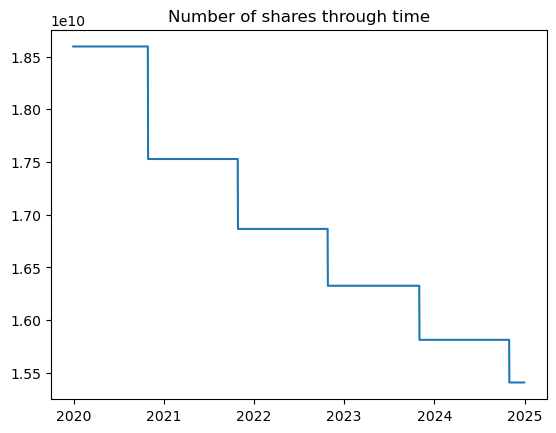

In [22]:
#Plot of outstanding shares 
plt.figure()

plt.title('Number of shares through time')

plt.plot(data.loc['AAPL.O']['Shares used to calculate Diluted EPS - Total'])

plt.show()


## Computing the value of the asset and its volatility

In [23]:
# df_k = pd.DataFrame()

# for ric in rics_list:
#     df = data.loc[ric]
#     df = df.reset_index()
#     df['Total_value'] = (df['Close Price'] * df['Shares used to calculate Diluted EPS - Total']) +df['Debt - Total']
#     # Compute log returns and rolling volatility
#     df['Log_Returns'] = np.log(df['Close Price'] / df['Close Price'].shift(1))
#     df['Rolling_Volatility'] = df['Log_Returns'].rolling(window=252).std() 
#     df = df.dropna(subset=['Rolling_Volatility'])
    
#     # Compute total asset value (equity + debt)
#     #df['Total_value'] = df['Market Capitalization'] + df['Debt - Total']
#     df['RIC'] = ric
#     df = df.set_index([f'RIC', 'Date'])
#     df = df.dropna(how='any')

#     # Drop rows with missing data
    

#     df_k = pd.concat([df, df_k])

# data = df_k.copy()

In [24]:
data.loc[rics_list[1]].describe()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,Log_Returns,Rolling_Volatility,Total_value
count,1258.0,1258.0,1258.0,1258.0,1258.0,1258.000000,1258.0
mean,301.120862,2795876788.553259,696629297912.21936,5921100158.982512,0.000844,0.435858,839043537412.55957
std,124.791399,104409770.047277,232457747031.115479,7357691236.093029,0.028596,0.110142,324285780110.595276
min,88.91,2629000000.0,315555188424.080017,0.0,-0.306391,0.254210,254774690000.0
25%,209.5925,2702000000.0,585320975487.75,523000000.0,-0.011683,0.354419,594188022500.0
50%,280.825,2859000000.0,778039626010.359985,581000000.0,0.001067,0.405224,795625770000.0
75%,346.275,2876000000.0,909628612618.719971,10610000000.0,0.014418,0.527885,990168400000.0
max,632.68,2921000000.0,935644813206.599976,19075000000.0,0.209307,0.705082,1682390719999.999756


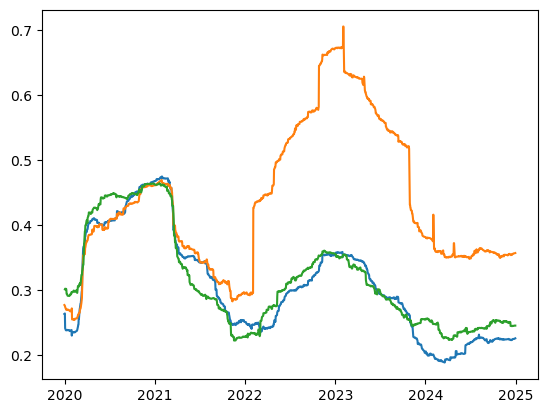

In [25]:
for ric in rics_list:

    plt.plot(data.loc[ric]['Rolling_Volatility'])

In [26]:
# Solve the system for each row
def solve_system(row):
    # Extract parameters from the row
    E = row['Close Price'] * row['Shares used to calculate Diluted EPS - Total'] # Equity (market capitalization)
    sigma_E = row['Rolling_Volatility']  # Rolling volatility as initial guess for sigma_A
    D = row['Debt - Total']          # Debt
    
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']        # Assume a risk-free rate column
    
    T = 1                            # Time to maturity (1 year)
    t = 0                            # Current time

    # Define the system of equations
    def system(vars):
        if D > 0:
            A, sigma_A = vars  # Unknowns: Asset value and asset volatility
            equity_value = af.merton_equity(A, D, r, sigma_A, T, t)
            d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * (T - t)) / (sigma_A * np.sqrt(T - t))
            f1 = equity_value - E  # Equation (2)
            f2 = (A / E) * norm.cdf(d1) * sigma_A - sigma_E  # Equation (4)

        else: 

            f1 = E 
            f2 = sigma_E
        return [f1, f2]

    # Initial guesses
    A_guess = row['Total_value']  # Total value (equity + debt)
    sigma_A_guess = row['Rolling_Volatility']  # Rolling volatility

    # Solve the system
    solution = fsolve(system, [A_guess, sigma_A_guess])
    return pd.Series({'A_solution': solution[0], 'sigma_A_solution': solution[1]})

# Apply the solver to the DataFrame
def solve_for_all(df):
    results = df.apply(solve_system, axis=1)
    return pd.concat([df, results], axis=1)


In [27]:
data.isna().sum()

Close Price                                     0
Shares used to calculate Diluted EPS - Total    0
Market Capitalization                           0
Debt - Total                                    0
RIC                                             0
Log_Returns                                     0
Rolling_Volatility                              0
Total_value                                     0
dtype: int64

In [28]:
df_with_solutions = solve_for_all(data)

c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\paolo\anaconda3\Lib\site-packages\scipy

In [29]:
df_with_solutions

Close Price  \
Instrument Date                                     
AAPL.O     2019-12-31 00:00:00+00:00      73.4125   
           2020-01-02 00:00:00+00:00      75.0875   
           2020-01-03 00:00:00+00:00      74.3575   
           2020-01-06 00:00:00+00:00        74.95   
           2020-01-07 00:00:00+00:00      74.5975   
...                                           ...   
BRBI.MI    2024-12-19 00:00:00+00:00        8.957   
           2024-12-20 00:00:00+00:00         8.99   
           2024-12-23 00:00:00+00:00        8.984   
           2024-12-27 00:00:00+00:00        9.126   
           2024-12-30 00:00:00+00:00        9.093   

                                      Shares used to calculate Diluted EPS - Total  \
Instrument Date                                                                      
AAPL.O     2019-12-31 00:00:00+00:00                                   18595652000   
           2020-01-02 00:00:00+00:00                                   18595652000   
           2020-01-03 00:00:00+00:00                                   18595652000   
           2020-01-06 00:00:00+00:00                                   18595652000   
           2020-01-07 00:00:00+00:00                                   18595652000   
...                                                                            ...   
BRBI.MI    2024-12-19 00:00:00+00:00                                     323640100   
           2024-12-20 00:00:00+00:00                                     323640100   
           2024-12-23 00:00:00+00:00                                     323640100   
           2024-12-27 00:00:00+00:00                                     323640100   
           2024-12-30 00:00:00+00:00                                     323640100   

                                      Market Capitalization    Debt - Total  \
Instrument Date                                                               
AAPL.O     2019-12-31 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-02 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-03 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-06 00:00:00+00:00         988886967600.0  108047000000.0   
           2020-01-07 00:00:00+00:00         988886967600.0  108047000000.0   
...                                                     ...             ...   
BRBI.MI    2024-12-19 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-20 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-23 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-27 00:00:00+00:00           3706536975.0     931124000.0   
           2024-12-30 00:00:00+00:00           3706536975.0     931124000.0   

                                          RIC  Log_Returns  \
Instrument Date                                              
AAPL.O     2019-12-31 00:00:00+00:00   AAPL.O      0.00728   
           2020-01-02 00:00:00+00:00   AAPL.O      0.02256   
           2020-01-03 00:00:00+00:00   AAPL.O     -0.00977   
           2020-01-06 00:00:00+00:00   AAPL.O     0.007937   
           2020-01-07 00:00:00+00:00   AAPL.O    -0.004714   
...                                       ...          ...   
BRBI.MI    2024-12-19 00:00:00+00:00  BRBI.MI    -0.016828   
           2024-12-20 00:00:00+00:00  BRBI.MI     0.003677   
           2024-12-23 00:00:00+00:00  BRBI.MI    -0.000668   
           2024-12-27 00:00:00+00:00  BRBI.MI     0.015682   
           2024-12-30 00:00:00+00:00  BRBI.MI    -0.003623   

                                      Rolling_Volatility      Total_value  \
Instrument Date                                                             
AAPL.O     2019-12-31 00:00:00+00:00            0.263392  1473200302450.0   
           2020-01-02 00:00:00+00:00            0.264154  1504348019550.0   
           2020-01-03 00:00:00+00:00            0.241447  1490773193590.0   
         

In [30]:
x = df_with_solutions['Close Price'] * df_with_solutions['Shares used to calculate Diluted EPS - Total']

asset_value = df_with_solutions['A_solution']

result = asset_value - x
result.describe()

count                 3790.0
mean      39153045280.647095
std       51269994354.154114
min                      0.0
25%         626263543.759302
50%         933859471.475763
75%      107716025602.245117
max      120643447506.040039
dtype: Float64

## Computing the relevant quantities of the Merton's model

In [31]:
def compute_additional_metrics(row):
    # Extract inputs from the row
    """
    V = row['Total_value']  # Asset value
    sigma = row['Rolling_Volatility']  # Asset volatility
    """
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.01
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    #M = 1_000_000

    # Compute quantities using the provided functions
    equity_value = af.merton_equity(V, K, r, sigma, T, t)
    debt_value = af.merton_debt(V, K, r, sigma, T, t)
    default_probability = af.default_probability(V, K, r, sigma, T, t)
    #mc_default_probability = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_sim = af.monte_carlo_merton_2(V, K, r, sigma, T, M)
    # mc_default_probability = mc_sim[2]
    credit_spread = af.credit_spread_model(V, K, sigma, r, T, t)
    #credit_spread_2 = af.credit_spread_model_new(V, K, sigma, r, T, t)


    # Return results as a Series
    return pd.Series({
        'Merton_Equity_Value': equity_value,
        'Merton_Debt_Value': debt_value,
        'Default_Probability': default_probability,
        #'MC_Default_Probability': mc_default_probability,
        'Credit_Spread': credit_spread
        
    })
#'Credit_Spread_2': credit_spread_2

In [33]:
importlib.reload(af)

# Compute additional metrics for each row
df_with_metrics = df_with_solutions.apply(compute_additional_metrics, axis=1)

# Combine results with the original DataFrame
df_final = pd.concat([df_with_solutions, df_with_metrics], axis=1)

#### Plotting the probability of default through time

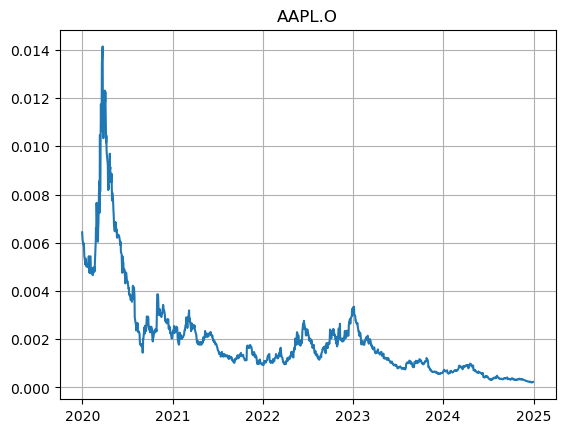

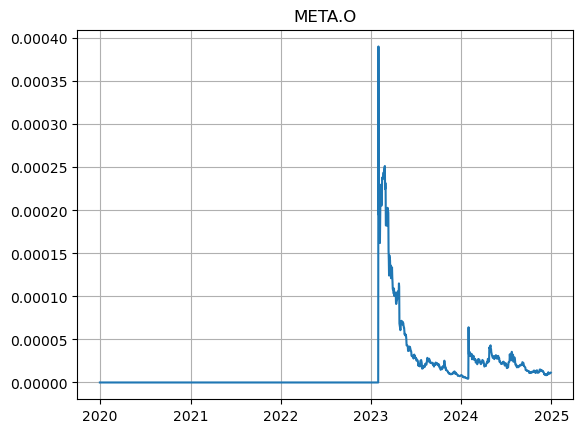

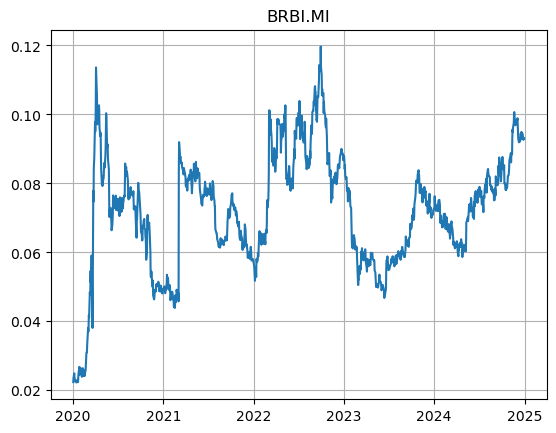

In [34]:
for ric in rics_list:
    plt.figure()

    def_probab = df_final.loc[ric]['Default_Probability']
    plt.plot(def_probab)
    plt.title(f'{ric}')

    plt.grid()

    plt.show()

##### Checking the results

In [35]:
df_final.loc[rics_list[2]].tail()

,Close Price,Shares used to calculate Diluted EPS - Total,Market Capitalization,Debt - Total,RIC,Log_Returns,Rolling_Volatility,Total_value,A_solution,sigma_A_solution,Merton_Equity_Value,Merton_Debt_Value,Default_Probability,Credit_Spread
Date,,,,,,,,,,,,,,
2024-12-19 00:00:00+00:00,8.957,323640100,3706536975.0,931124000.0,BRBI.MI,-0.016828,0.245158,3829968375.7,3.793458e+09,0.187347,2.871599e+09,9.218592e+08,0.094934,9.992007e-16
2024-12-20 00:00:00+00:00,8.99,323640100,3706536975.0,931124000.0,BRBI.MI,0.003677,0.245199,3840648499.0,3.804139e+09,0.187541,2.882279e+09,9.218592e+08,0.094477,9.992007e-16
2024-12-23 00:00:00+00:00,8.984,323640100,3706536975.0,931124000.0,BRBI.MI,-0.000668,0.244963,3838706658.4,3.802197e+09,0.187331,2.880338e+09,9.218592e+08,0.094545,9.992007e-16
2024-12-27 00:00:00+00:00,9.126,323640100,3706536975.0,931124000.0,BRBI.MI,0.015682,0.245513,3884663552.6,3.848154e+09,0.188441,2.926294e+09,9.218592e+08,0.092629,7.771561e-16
2024-12-30 00:00:00+00:00,9.093,323640100,3706536975.0,931124000.0,BRBI.MI,-0.003623,0.245485,3873983429.3,3.837474e+09,0.188261,2.915614e+09,9.218592e+08,0.093076,8.881784e-16


In [51]:
importlib.reload(af)

row = df_final.loc[rics_list[2]].iloc[-1]
V = row['A_solution']
sigma = row['sigma_A_solution'] 

K = row['Debt - Total']  # Debt
row['Risk_Free_Rate'] = 0.01
r = row['Risk_Free_Rate']

#print(V/K)

T = 1  # Time to maturity
t = 0  # Current time
M = 1_000_000

l = af.monte_carlo_merton(V,K, r, sigma, T, M)


1000000
0


#### Obtaining the value of the normal distribution for which the value of assets becomes equal to the debt

In [52]:
def find_boundary_W_T(V_0, K, sigma, T):
    """
    Finds the scalar W_T such that the asset value V_T in the
    monte_carlo_merton dynamics equals the debt face value K.

    Parameters
    ----------
    V_0 : float
        Current asset value.
    K : float
        Debt face value (or strike).
    sigma : float
        Volatility of the firm's asset process.
    T : float
        Time to maturity.

    Returns
    -------
    float
        The unique W_T that makes V_T = K in the
        V_T = V_0 * exp((0 - 0.5 * sigma^2)*T + sigma * W_T) model.
    """
    numerator = np.log(K / V_0) + 0.5 * sigma**2 * T
    W_T_star = numerator / sigma
 
    return W_T_star

# if __name__ == "__main__":
#     # Example parameters
#     V_0_ex = 100.0   # current asset value
#     K_ex   = 90.0    # debt face value
#     sigma_ex = 0.2   # volatility
#     T_ex   = 1.0     # time in years

#     # Solve for W_T*
#     W_T_solution = find_boundary_W_T(V_0_ex, K_ex, sigma_ex, T_ex)

#     print(f"W_T that sets V_T = {K_ex} is: {W_T_solution:.6f}")

W_T_solution = find_boundary_W_T(V, K, sigma, T)
print(f"W_T that sets V_T = {K} is: {W_T_solution:.6f}")
print(row)
print(norm.cdf(W_T_solution))

check = V* np.exp( ((0 - 0.5 * sigma**2) * T) + (sigma * W_T_solution))
print(f'Check: {check- K}')

W_T that sets V_T = 931124000.0 is: -7.428267
Close Price                                                 9.093
Shares used to calculate Diluted EPS - Total            323640100
Market Capitalization                                3706536975.0
Debt - Total                                          931124000.0
RIC                                                       BRBI.MI
Log_Returns                                             -0.003623
Rolling_Volatility                                       0.245485
Total_value                                          3873983429.3
A_solution                                      3837473535.041267
sigma_A_solution                                         0.188261
Merton_Equity_Value                             2915614373.641407
Merton_Debt_Value                                 921859161.39986
Default_Probability                                      0.093076
Credit_Spread                                                 0.0
Risk_Free_Rate                

#### Debugging the credit spread

In [38]:
r = 0.01
T = 1
t = 0

sigma = 0.25


V = 3837473534.932722
#K = 931124000.0 * 2


p_0 = np.exp(-r * (T - t))
K = (V * 0.6) / p_0

# 2) Calculate d1 and d2
d1 = (-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t)) / (sigma * np.sqrt(T -t))

d2 = d1 - (sigma * np.sqrt(T - t))

# 3) *Defaultable* bond price using Merton's debt formula
#defaultable_bond = K * riskless * norm.cdf(d2) + V * (1 - norm.cdf(d1))

# 4) Credit spread calculation: -1/(T - t) * ln(defaultable_bond / riskless_bond)
credit_spread = -1/(T - t) * np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))

print(f'Debt-to-value: {K/V}')
print(f'Log: {-(np.log((K*p_0)/V))}')
print(f'Numerator: {(-(np.log((K*p_0)/V)) + (0 + 0.5*sigma**2) * (T - t))}')
print(f'Volatility: {sigma}')
print(f'd1: {d1}')
print(f'First addend: {np.log(norm.cdf(d2) )}' )
print(f'Second addend: {(V/(K *p_0))*norm.cdf(-d1)}')
print(f'Not discounted: {-np.log(norm.cdf(d2) + (V/(K *p_0))*norm.cdf(-d1))}')
print(f'Credit spread: {credit_spread}')

Debt-to-value: 0.6060301002505009
Log: 0.5108256237659907
Numerator: 0.5420756237659907
Volatility: 0.25
d1: 2.168302495063963
First addend: -0.027922564726853342
Second addend: 0.025113065607051538
Not discounted: 0.00242620838220305
Credit spread: 0.00242620838220305


In [40]:
#Test the credit spread model with mock examples
af.credit_spread_model(V = 40, K = 15, sigma = 0.4, r = 0.04, T = 5, t = 0)

0.013587038390588863

## Montecarlo simulations of the last observed day of each stock

We need a large number of simulations given the extremely low probabilities we obtain for highly capitalized firms 

In [41]:
data.loc[ric].iloc[-1,:]

Close Price                                            9.093
Shares used to calculate Diluted EPS - Total       323640100
Market Capitalization                           3706536975.0
Debt - Total                                     931124000.0
RIC                                                  BRBI.MI
Log_Returns                                        -0.003623
Rolling_Volatility                                  0.245485
Total_value                                     3873983429.3
Name: 2024-12-30 00:00:00+00:00, dtype: object

In [43]:
row

Close Price                                                 9.093
Shares used to calculate Diluted EPS - Total            323640100
Market Capitalization                                3706536975.0
Debt - Total                                          931124000.0
RIC                                                       BRBI.MI
Log_Returns                                             -0.003623
Rolling_Volatility                                       0.245485
Total_value                                          3873983429.3
A_solution                                      3837473535.041267
sigma_A_solution                                         0.188261
Merton_Equity_Value                             2915614373.641407
Merton_Debt_Value                                 921859161.39986
Default_Probability                                      0.093076
Credit_Spread                                                 0.0
Risk_Free_Rate                                               0.01
Name: 2024

In [49]:
931124000.0 / 3837473535.041267

0.24263984923872237

In [141]:
rics_list 


['AAPL.O', 'META.O', 'BRBI.MI']

In [144]:
importlib.reload(af)
import time as time
mc_probabilities = {}
rics_paths = {}

for ric in rics_list[:2]:

    row = df_with_solutions.loc[ric].iloc[-1]
    V = row['A_solution']
    sigma = row['sigma_A_solution']
    
    K = row['Debt - Total']  # Debt
    row['Risk_Free_Rate'] = 0.04
    r = row['Risk_Free_Rate']
    
    #print(V/K)

    T = 1  # Time to maturity
    t = 0  # Current time
    M = 1_000_000
    print('-'*100)
    merton_prob = af.default_probability(V, K, r, sigma, T , t)
    mc_prob = af.monte_carlo_merton(V, K, r, sigma, T, M)
    mc_prob_anti = af.monte_carlo_merton_anti(V, K, r, sigma, T, M)

    mc_probabilities[ric] = mc_prob
    print(f'Merton probability is: {merton_prob}')
    print(f'Monte Carlo Merton is: {mc_prob}')


    print('%' *100)
    W_T_solution = find_boundary_W_T(V, K, sigma, T)
    print(f"W_T that sets V_T = {K} is: {W_T_solution:.6f}")
    #print(row)
    print(norm.cdf(W_T_solution))

    check = V* np.exp( ((0 - 0.5 * sigma**2) * T) + (sigma * W_T_solution))
    print(f'Check: {check- K}')
    st = time.time()

    steps = 2000
    batch_size = 10_000
    mc_prob_2 = af.monte_carlo_path_batched(V, K, r, sigma, T, M, steps, batch_size)
    et = time.time()

    print(f'TIme elapsed = {et- st}')
    #rics_paths[ric] = paths

    

----------------------------------------------------------------------------------------------------
Min log(V_T): 27.891974579457855, Max log(V_T): 30.04958821116183, Threshold: 25.40098921561621
Min log(V_T) - Anti: 27.707703265601815, Max log(V_T) - Anti: 30.27310371803703, Threshold - Anti: 25.40098921561621
Merton probability is: 0.00022951234009258115
Monte Carlo Merton is: 0.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
W_T that sets V_T = 107525000000.0 is: -16.310140
4.1800249253638224e-60
Check: -1.52587890625e-05
The defaults with batched paths is: 0
TIme elapsed = 77.47602796554565


In [93]:
rics_paths[ric].shape

(1000, 757)

The defaults with paths is: 1


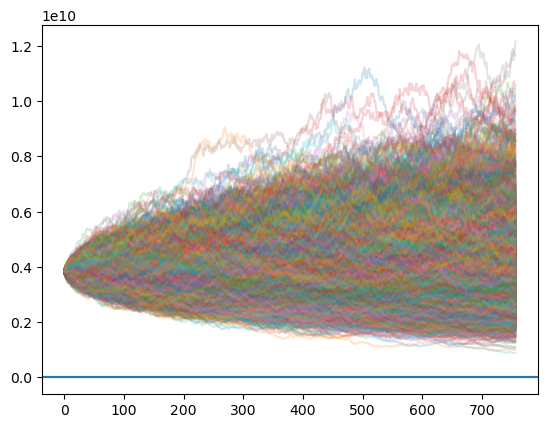

In [103]:
plt.figure()

ric = rics_list[-1]
M = 10000
mc_prob_2, paths = af.monte_carlo_path(V, K, r, sigma, T, M)
rics_paths[ric] = paths


paths_sing = rics_paths[ric]

if mc_prob_2 > 0:

    plt.axhline(np.log(V))

    for i in range(paths_sing.shape[0]):

        plt.plot(paths_sing[i, :], alpha = 0.2)

    plt.axhline(np.log(K))

    plt.show()

In [91]:
final_values = paths_sing[:,-1]

x = np.median(final_values)

print(np.log(V) - x)

-3620940229.2267394


In [68]:
print(f'Value of assets: {V}')

print(f'Value of debt total: {K}')

Value of assets: 3837473535.0412674
Value of debt total: 931124000.0


In [66]:
print('Hello')

Hello


## Ratings of S&P 500

In [45]:
ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI)',
                                        'TR.IssuerRating(IssuerRatingSrc=SPI,Sdate=-10Y)'])
print(ratings_data.head())

ratings_data, err = ek.get_data(instruments=['0#.SPX'], 
                                fields=['TR.CommonName',
                                        'TR.IssuerRating'])
print(ratings_data.head())

c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


  Instrument        Company Common Name  Issuer Rating  Issuer Rating
0    POOL.OQ                  Pool Corp           <NA>           <NA>
1    CHRW.OQ  CH Robinson Worldwide Inc           <NA>           <NA>
2      AJG.N  Arthur J. Gallagher & Co.           <NA>           <NA>
3      CNP.N     CenterPoint Energy Inc           <NA>           <NA>
4     AMCR.N                  Amcor PLC           <NA>           <NA>
  Instrument        Company Common Name Issuer Rating
0    POOL.OQ                  Pool Corp           A1+
1    CHRW.OQ  CH Robinson Worldwide Inc           A1+
2      AJG.N  Arthur J. Gallagher & Co.          Baa2
3      CNP.N     CenterPoint Energy Inc          Baa3
4     AMCR.N                  Amcor PLC          Baa2


c:\Users\paolo\anaconda3\Lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [46]:
ratings_data['Issuer Rating'].value_counts()

Issuer Rating
Baa2            51
Baa1            49
A1+             39
A1              39
                35
P-2             30
A2              25
Baa3            24
A3              20
NR              19
BBB             17
A               13
P-1             12
BBB+            11
Ba1             11
Aa3             10
BBB-             9
WR               9
A-               7
F1               6
A+               6
WD               6
Ba2              6
Discontinued     5
BB+              4
BB               4
F2               4
Aa2              4
P-3              3
Ba3              2
BB-              2
B-               2
B1               2
F3               2
AA-              2
B                2
LGD2 - 20%       1
Aaa              1
LGD4 - 68%       1
(P)Baa3          1
B+               1
LGD5 - 74%       1
LGD5 - 81%       1
(P)A2            1
AA               1
(P)Baa2          1
LGD4 - 54%       1
Name: count, dtype: Int64

In [47]:
ratings_data[ratings_data['Issuer Rating'] == 'B1']

,Instrument,Company Common Name,Issuer Rating
63,DAY.N,Dayforce Inc,B1
346,CZR.OQ,Caesars Entertainment Inc,B1
